# MAVLink Anomaly Detection Using Machine Learning

This notebook implements anomaly detection for MAVLink messages using Isolation Forest and Local Outlier Factor (LOF) algorithms.

In [14]:
# Define the path to the pcap files and the output directory
csv_directory = "../datasets/mavlink"
output_directory = "./model_output"

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import joblib

In [13]:
plt.style.use('ggplot')
sns.set_palette("husl")

## 1. Load Data

In [19]:
def load_mavlink_data(data_dir):
    """Load all CSV files from directory and combine them"""
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Directory {data_dir} does not exist")

    data_path = Path(data_dir)
    all_data = []
    
    index = 0
    for csv_file in os.listdir(data_dir):
        if csv_file.endswith('.csv'):
          df = pd.read_csv(data_path / csv_file)
          # Add source file as a column
          df['source_file'] = csv_file
          all_data.append(df)
          index += 1

          print(f"File Loaded. {index}: {csv_file} - {len(df)} records")
    
    return pd.concat(all_data, ignore_index=True)

# Load all data
df = load_mavlink_data(csv_directory)
print(f"Loaded {len(df)} records from {df['source_file'].nunique()} files")

/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 1: mavlink_data_20241101_160537.csv - 59671 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (75) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 2: mavlink_data_20241101_161005.csv - 65792 records
File Loaded. 3: mavlink_data_20241031_102918.csv - 1 records
File Loaded. 4: mavlink_data_20241031_103254.csv - 1 records
File Loaded. 5: mavlink_data_20241118_000809_ggd.csv - 4273 records
File Loaded. 6: mavlink_data_20241031_103524.csv - 2376 records
File Loaded. 7: mavlink_data_20241101_170019.csv - 39119 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (38,88,99,101,120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 8: mavlink_data_20241101_151428.csv - 44798 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (82,112) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (38,88,99,119) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 9: mavlink_data_20241101_162424.csv - 90471 records
File Loaded. 10: mavlink_data_20241117_234604_gpj.csv - 15126 records
File Loaded. 11: mavlink_data_20241101_153956.csv - 1 records
File Loaded. 12: mavlink_data_20241031_102358.csv - 21851 records
File Loaded. 13: mavlink_data_20241031_102619.csv - 2528 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 14: mavlink_data_20241101_154428.csv - 72904 records
File Loaded. 15: mavlink_data_20241101_155905.csv - 159 records
File Loaded. 16: mavlink_data_20241031_103539.csv - 3629 records
File Loaded. 17: mavlink_data_20241101_152514.csv - 616 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 18: mavlink_data_20241101_152504.csv - 81420 records
File Loaded. 19: mavlink_data_20241101_152510.csv - 3944 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (38,88,99,101,120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (81,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 20: mavlink_data_20241101_171646.csv - 103644 records
File Loaded. 21: mavlink_data_20241117_234731_rf.csv - 21672 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 22: mavlink_data_20241101_153508.csv - 64930 records
File Loaded. 23: mavlink_data_20241101_161341.csv - 50579 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (34,82,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (82,112) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 24: mavlink_data_20241101_153913.csv - 56409 records
File Loaded. 25: mavlink_data_20241117_234716_rn.csv - 13760 records
File Loaded. 26: mavlink_data_20241031_103228.csv - 22775 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (87,98,99,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 27: mavlink_data_20241101_170936.csv - 103923 records
File Loaded. 28: mavlink_data_20241031_102913.csv - 33031 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (87,98,99,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 29: mavlink_data_20241101_163432.csv - 135705 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 30: mavlink_data_20241101_151906.csv - 59743 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/4286704174.py:12: DtypeWarning: Columns (34,82,93,95,114) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 31: mavlink_data_20241101_164607.csv - 76878 records
Loaded 1251729 records from 31 files


## 2. Data Visualization

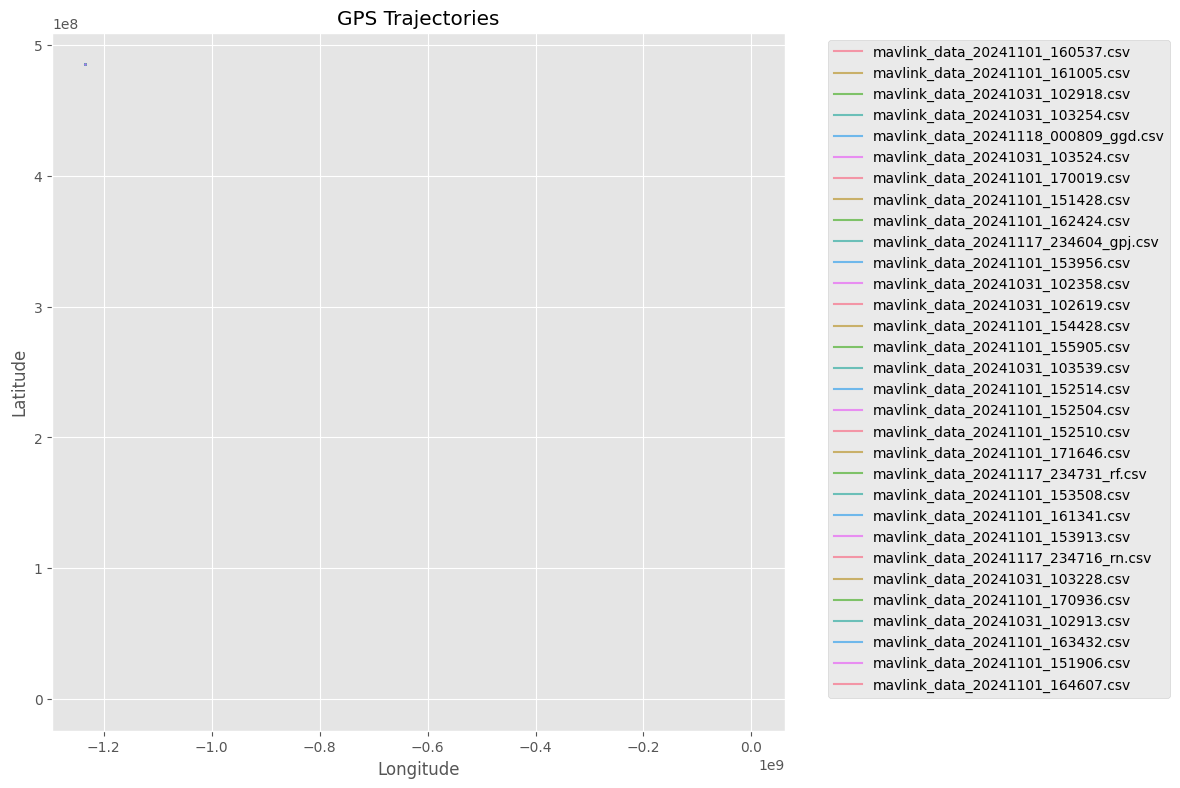

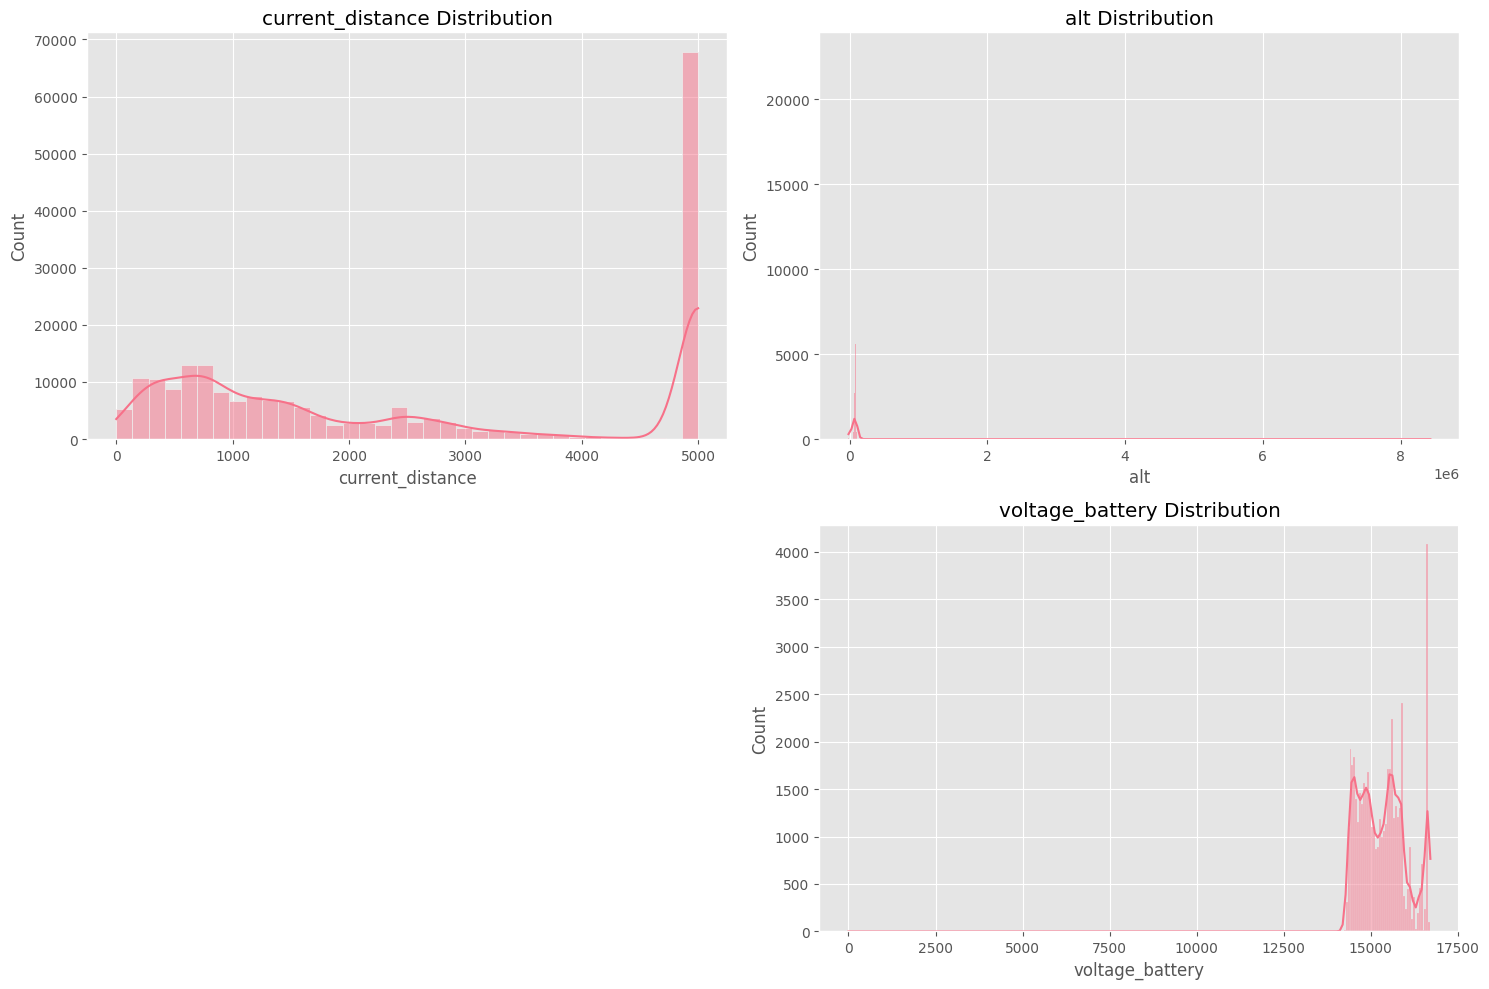

/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/2125338050.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


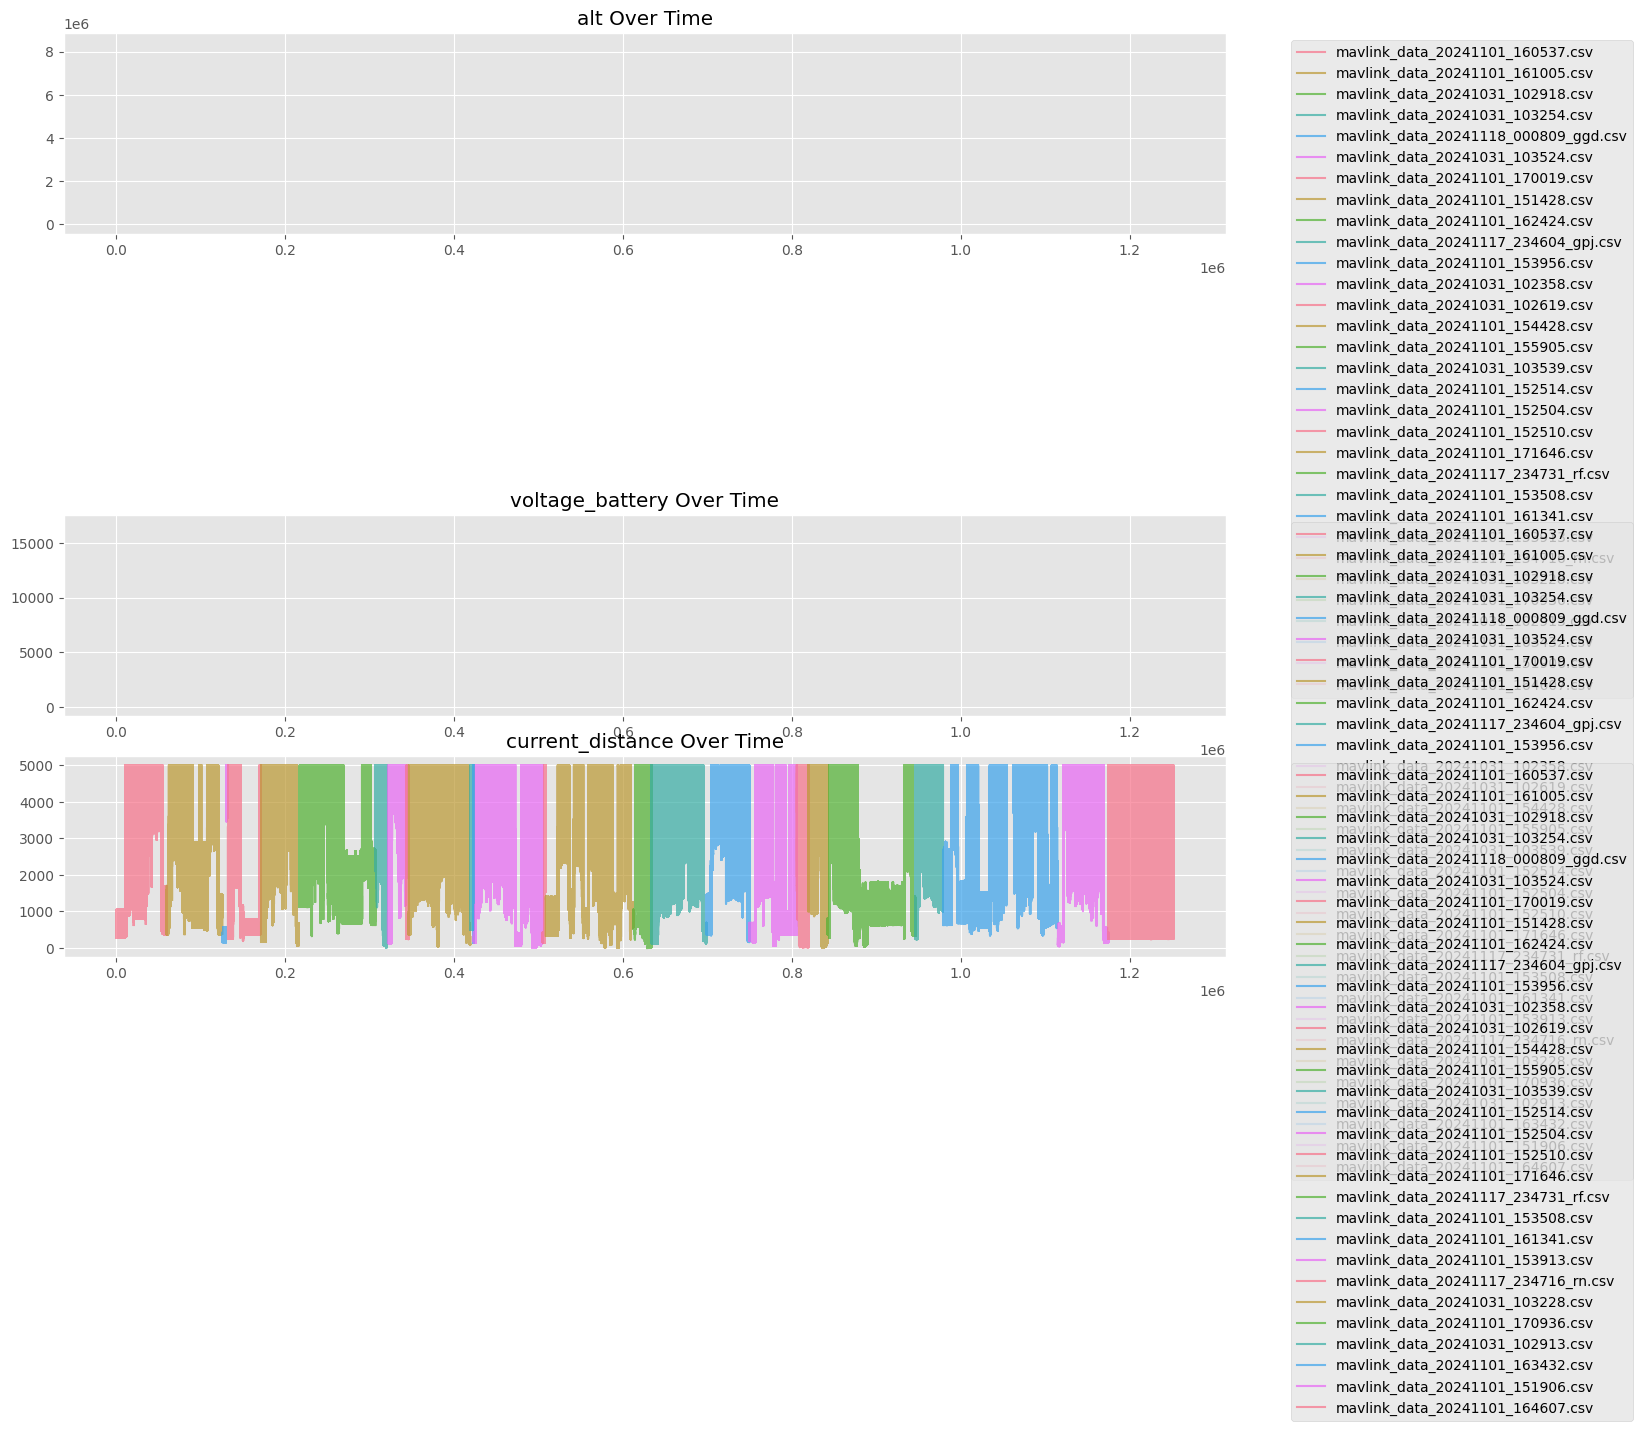

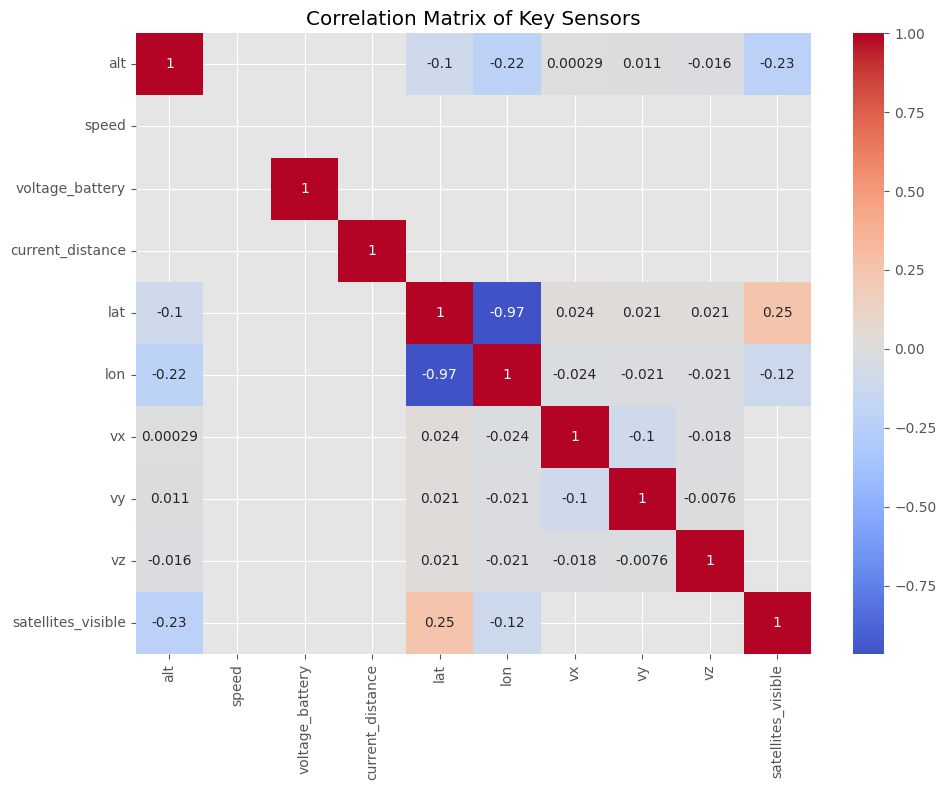

In [21]:
def plot_gps_trajectory(df):
    """Plot GPS trajectories"""
    plt.figure(figsize=(12, 8))
    for file in df['source_file'].unique():
        file_data = df[df['source_file'] == file]
        plt.plot(file_data['longitude'], file_data['latitude'], 
                label=file, alpha=0.7)
    plt.title('GPS Trajectories')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_sensor_distributions(df):
    """Plot distributions of key sensor readings"""
    sensors = ['current_distance', 'alt', 'groundspeed', 'voltage_battery']
    plt.figure(figsize=(15, 10))
    
    for i, sensor in enumerate(sensors, 1):
        if sensor in df.columns:
            plt.subplot(2, 2, i)
            sns.histplot(df[sensor].dropna(), kde=True)
            plt.title(f'{sensor} Distribution')
            
    plt.tight_layout()
    plt.show()

def plot_time_series(df):
    """Plot time series of key measurements"""
    metrics = ['alt', 'groundspeed', 'voltage_battery', 'current_distance']
    plt.figure(figsize=(15, 12))
    
    for i, metric in enumerate(metrics, 1):
        if metric in df.columns:
            plt.subplot(len(metrics), 1, i)
            for file in df['source_file'].unique():
                file_data = df[df['source_file'] == file]
                plt.plot(file_data.index, file_data[metric], 
                        label=file, alpha=0.7)
            plt.title(f'{metric} Over Time')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Generate plots
plot_gps_trajectory(df)
plot_sensor_distributions(df)
plot_time_series(df)

# Correlation analysis
sensor_cols = ['alt', 'speed', 'voltage_battery', 'current_distance',
    'lat', 'lon', 'vx', 'vy', 'vz', 'satellites_visible']
corr_matrix = df[sensor_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Key Sensors')
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [24]:
def engineer_features(df):
    """Create features for anomaly detection with proper NaN handling"""
    features = pd.DataFrame()
    
    # First get timestamps for temporal features
    if 'time_boot_ms' in df.columns:
        features['timestamp'] = pd.to_numeric(df['time_boot_ms'], errors='coerce')
    elif 'time_usec' in df.columns:
        features['timestamp'] = pd.to_numeric(df['time_usec'], errors='coerce') / 1000
    
    # GPS-based features
    gps_cols = ['lat', 'lon', 'alt', 'vx', 'vy', 'vz']
    if all(col in df.columns for col in gps_cols):
        # Calculate speed from velocity components
        features['gps_speed'] = np.sqrt(
            df['vx'].fillna(0)**2 + 
            df['vy'].fillna(0)**2
        )
        features['gps_vert_speed'] = df['vz'].fillna(0)
        
        # Add position accuracy if available
        if 'eph' in df.columns:
            features['gps_accuracy'] = df['eph'].fillna(method='ffill')
    
    # Rangefinder features
    if 'current_distance' in df.columns:
        features['ground_distance'] = df['current_distance'].fillna(method='ffill')
        if 'signal_quality' in df.columns:
            features['distance_quality'] = df['signal_quality'].fillna(0)
    
    # IMU-based features
    imu_cols = ['xacc', 'yacc', 'zacc']
    if all(col in df.columns for col in imu_cols):
        # Fill NaN with 0 for acceleration components
        features['total_acceleration'] = np.sqrt(
            df['xacc'].fillna(0)**2 + 
            df['yacc'].fillna(0)**2 + 
            df['zacc'].fillna(0)**2
        )
    
    # System status features
    if 'voltage_battery' in df.columns:
        features['voltage'] = df['voltage_battery'].fillna(method='ffill')
    
    # Calculate rolling statistics
    window = 10  # 10-point rolling window
    for col in features.columns:
        if col != 'timestamp':  # Skip timestamp for rolling calculations
            features[f'{col}_roll_mean'] = features[col].rolling(
                window, min_periods=1).mean()
            features[f'{col}_roll_std'] = features[col].rolling(
                window, min_periods=1).std().fillna(0)
    
    # Drop columns with too many NaN values
    nan_ratio = features.isna().sum() / len(features)
    features = features.drop(columns=nan_ratio[nan_ratio > 0.5].index)
    
    # Final NaN cleanup
    # 1. Forward fill remaining NaNs
    features = features.fillna(method='ffill')
    # 2. Backward fill any remaining NaNs at the start
    features = features.fillna(method='bfill')
    # 3. Fill any still remaining NaNs with 0
    features = features.fillna(0)
    
    # Remove timestamp if it was added
    if 'timestamp' in features.columns:
        features = features.drop(columns=['timestamp'])
    
    # Verify no NaNs remain
    assert not features.isna().any().any(), "NaN values still present in features"
    
    return features

# Create and prepare feature matrix
print("Engineering features...")
X = engineer_features(df)
print("Created features:", X.columns.tolist())

# Verify no NaNs in feature matrix
print("\nFeature matrix shape:", X.shape)
print("NaN values remaining:", X.isna().sum().sum())

# Scale features
print("\nScaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Additional check for NaNs after scaling
assert not np.isnan(X_scaled).any(), "NaN values found after scaling"

print("Feature engineering complete!")

Engineering features...


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/1627332434.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['gps_accuracy'] = df['eph'].fillna(method='ffill')
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/1627332434.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['ground_distance'] = df['current_distance'].fillna(method='ffill')
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/1627332434.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features['voltage'] = df['voltage_battery'].fillna(method='ffill')
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_41411/1627332434.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated 

Created features: ['gps_speed', 'gps_vert_speed', 'gps_accuracy', 'ground_distance', 'distance_quality', 'total_acceleration', 'voltage', 'gps_speed_roll_mean', 'gps_speed_roll_std', 'gps_vert_speed_roll_mean', 'gps_vert_speed_roll_std', 'gps_accuracy_roll_mean', 'gps_accuracy_roll_std', 'ground_distance_roll_mean', 'ground_distance_roll_std', 'distance_quality_roll_mean', 'distance_quality_roll_std', 'total_acceleration_roll_mean', 'total_acceleration_roll_std', 'voltage_roll_mean', 'voltage_roll_std']

Feature matrix shape: (1251729, 21)
NaN values remaining: 0

Scaling features...
Feature engineering complete!


## 4. Model Training

In [ ]:
def train_isolation_forest(X_scaled):
    """Train Isolation Forest model"""
    print("Training Isolation Forest...")

    iso_forest = IsolationForest(
        n_estimators=100,
        contamination=0.1,  # Expected proportion of anomalies
        random_state=42
    )
    iso_forest.fit(X_scaled)
    return iso_forest

def train_lof(X_scaled):
    """Train Local Outlier Factor model"""
    print("Training Local Outlier Factor...")

    lof = LocalOutlierFactor(
        n_neighbors=20,
        contamination=0.1,
        novelty=True  # Enable predict method
    )
    lof.fit(X_scaled)
    return lof

# Split data
print("Splitting data...")
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Train models
iso_forest = train_isolation_forest(X_train)
lof = train_lof(X_train)

print("Models trained successfully")

ValueError: Input X contains NaN.
IsolationForest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values